# OSHA Exposure Training Data: Analysis, Visualization, & Modeling Insights
**Author:** Jacob Kvasnicka <br>
**Date:** January 7, 2025

## Background
We are developing a high-throughput modeling framework to predict a chemical's Margin of Exposure (MOE) by integrating:
1. **QSAR Model**:
   - Predicts human-equivalent Points of Departure (POD)
2. **Machine Learning Exposure Model**:
   - Predicts exposure concentrations in U.S. workplaces

![Integrated Modeling Framework](modeling_framework.png)
Thee POD modssl demonstrated sufficient performance:
- Typical prediction error within a factor of 5 mg/m³
- Approximately 50% of the variance explained
    .This notebook focuses nsdeveloping an exposure model based on a similar machine-learning approach::
- **Features**: Represent chemical and industry-specific (exposure context) information.
- **Target Variable**: Represents an exposure concentration that is directly comparable to the PO
- 

---

## Notebook Organization
This notebook is organized into three main sections:
1. **Overview of Raw Datasets**:
   - Highlightss commonalities and differences between CEHD and USIS datasets.
2. **Data Cleaning Pipelines**:
   - Summarizes the workflows for preparing cleaned CEHD and USIS datasets for machine learning.
3. **Training Set Preparation**:
   - Describess the steps for deriving a representative target variable and features for the exposure model.

In [ ]:
# TODO: Map the NAICS codes to labels?

In [1]:
import pandas as pd
import numpy as np 
import os 
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
import math
from scipy.stats import linregress
from scipy.stats import spearmanr 
from scipy.stats import f_oneway
import joblib

from config_management import UnifiedConfiguration
from raw_processing import (
    cehd_cleaning, 
    usis_cleaning,
    osha_cleaning,
    cehd_processing,
    usis_processing,
    osha_processing
)
import data_management
import plot

config = UnifiedConfiguration()

## 1. Overview of Raw Datasets

We are using two OSHA datasets, collectively comprising the largest database of industrial hygiene air measurements in North America:

- **USIS (United States Information System):** Aggregates two datasets, including the legacy Integrated Management Information System (IMIS) (1971–2015) and its next-generation replacement, OSHA Information System (OIS) (2011–2021). 
- **CEHD (Chemical Exposure Health Data):** Includes all OSHA measurements analyzed by the Salt Lake Technical Center from 1984 through the latest dataset (2023 release). Includes some overlapping records with USIS.

Further details about these datasets can be found in a previous notebook.  

![Conceptual Linkage](concept_figure.png)

In [6]:
usis_cleaner = usis_cleaning.UsisCleaner(config.usis, config.path, config.comptox)
cehd_cleaner = cehd_cleaning.CehdCleaner(config.cehd, config.path, config.comptox)

In [7]:
raw_usis = usis_cleaner.load_raw_data()
raw_cehd = cehd_cleaner.load_raw_data()

In [8]:
raw_usis.shape

(765337, 50)

In [9]:
raw_usis.columns

Index(['inspection_id', 'inspection_number', 'original_db',
       'inspection_type_id', 'inspection_type_name', 'scope_id', 'scope_name',
       'was_notified', 'is_unionized', 'number_of_covered', 'agency_id',
       'agency_type', 'workplace_id', 'establishment_id', 'establishment_type',
       'location_id', 'territory_id', 'territory_name', 'city', 'zip',
       'sic_id', 'sic_name', 'naics_id', 'naics_name', 'sheet_id',
       'sheet_number', 'exposure_duration', 'duration_unit', 'record_id',
       'number_of_exposed', 'occ_id', 'occ_name', 'occ_title', 'job_title',
       'exposure_frequency', 'sample_date', 'sample_type_id',
       'sample_type_name', 'exposure_assessment', 'substance_id',
       'substance_name', 'is_detected', 'exposure_level', 'measure_unit_id',
       'measure_unit_name', 'exposure_type_id', 'exposure_type_name', 'oel',
       'severity', 'year'],
      dtype='object')

CEHD has more samples, because the USIS data were aggregated into full-shift Time Weighted Average (TWA) concentrations, whereas the raw CEHD contains partial-shift measurements in a disaggregated format.

In [10]:
raw_cehd.shape

(2604837, 26)

In [11]:
raw_cehd.columns

Index(['AIR_VOLUME_SAMPLED', 'BLANK_USED', 'CITY', 'DATE_REPORTED',
       'DATE_SAMPLED', 'EIGHT_HOUR_TWA_CALC', 'ESTABLISHMENT_NAME',
       'FIELD_NUMBER', 'IMIS_SUBSTANCE_CODE', 'INSPECTION_NUMBER',
       'INSTRUMENT_TYPE', 'LAB_NUMBER', 'NAICS_CODE', 'OFFICE_ID', 'QUALIFIER',
       'SAMPLE_RESULT', 'SAMPLE_TYPE', 'SAMPLE_WEIGHT', 'SAMPLING_NUMBER',
       'SIC_CODE', 'STATE', 'SUBSTANCE', 'TIME_SAMPLED', 'UNIT_OF_MEASUREMENT',
       'YEAR', 'ZIP_CODE'],
      dtype='object')

### Hierarchical Structure of OSHA Measurement Data

The OSHA data are organized hierarchically as follows:

1. **Sampling Number**:
   - Unique identifier tied to the Air Sampling Worksheet (OSHA 91A).
   - Represents an individual “evaluation” for a worker (e.g., a worker’s full shift).
   - Provides a link between the USIS and CEHD datasets.
   - In CEHD:
     - Multiple samples for a given chemical and sampling number correspond to partial-shift measurements.
     - OSHA inspectors will aggregate these measurements into a TWA before recording in USIS.

2. **Inspection Number**:
   - Unique identifier for each OSHA inspection of a specific workplace.
   - May involve several workers, and therefore several sampling numbers.

3. **Industry Classification**:
   - Represented by:
     - Four-digit **Standard Industrial Classification (SIC)** codes (1972 or 1987).
     - Six-digit **North American Industry Classification System (NAICS)** codes (introduced after 1997).

## 2. Data Cleaning Pipelines

I implemented a data cleaning pipeline for the CEHD and USIS datasets, to ensure consistent, high-quality data for modeling, while harmonizing the datasets into a consistent manner, enabling them to be combined into a single training set. The cleaning steps generally included the following:
- Remove nonpersonal samples: Retainining only personal samples ensures that the concentration measurements are best representative of external exposure.
- Convert to mass concentration: Conversion of units of PPM and % to mg/m3 ensures that the concentration measurements are directly comparable to the Points of Departure with the same units. Records with units that could not be converted (e.g., fibers per cubic centimeter) were removed.
- Convert raw substance names to DTXSIDs: This step enables the retrieval of chemical-specific information from external sources, such as physical-chemical properties for modeling, etc. Substances that could not be matched to a DTXSID were removed.
- Harmonize NAICS codes: Standardized historical SIC and NAICS codes in the dataset to the most recent 2022 NAICS standard for consistency.
- Remove non-full-shift TWAs (USIS): These included short-term samples aimed at capturing maximum exposures during a given workshift. Only full-shift TWA measurements were retained, representative of subchronic or chronic exposure for comparison with the PODs.

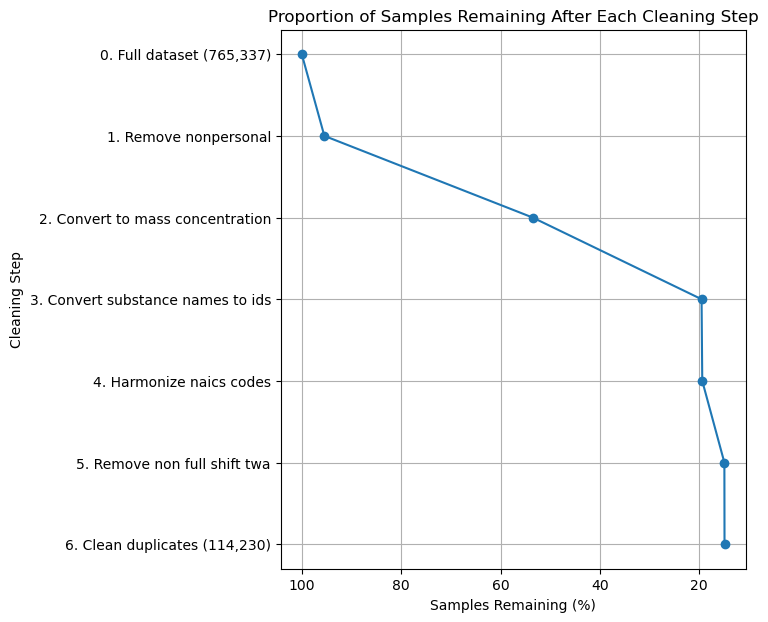

In [12]:
usis_initial_count = len(raw_usis)

_ = plot.cumulative_changes(
    config.path['usis_log_file'], 
    usis_initial_count
)

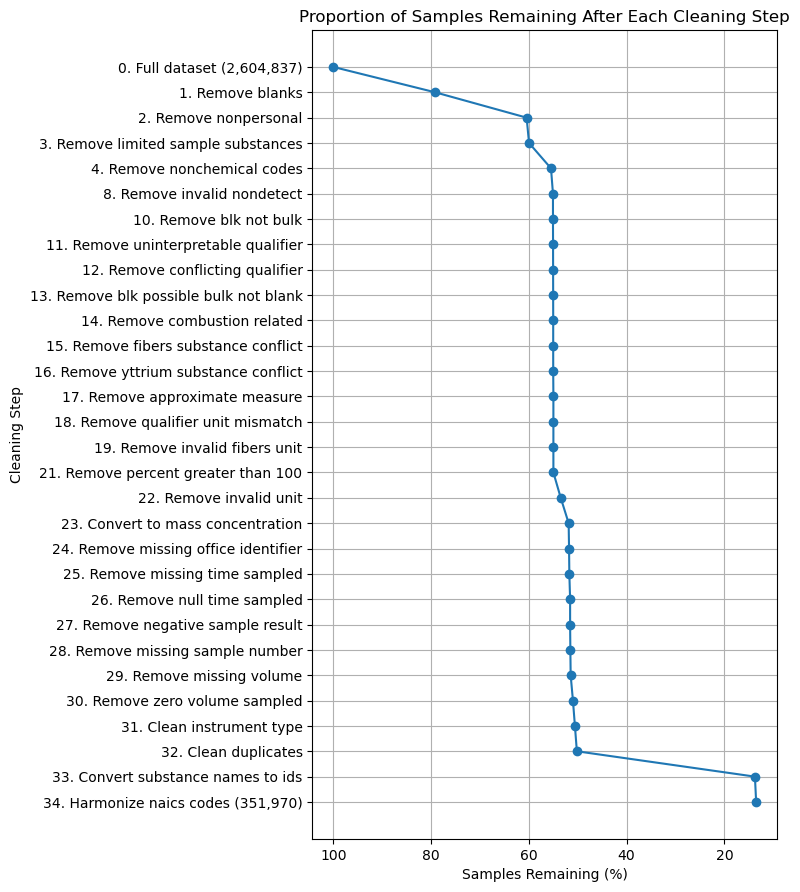

In [13]:
cehd_initial_count = len(raw_cehd)

_ = plot.cumulative_changes(
    config.path['cehd_log_file'], 
    cehd_initial_count
)

## 3. Training Set Preparation

The target variable in our modeling framework must be directly comparable to the POD for calculating a Margin of Exposure (MOE) for risk-based screening. Fortunately, the POD predictions:
- Are expressed in air concentration units [mg/m³].
- Were derived from chronic studies and adjusted from animals to humans using a "Dosimetric Adjustment Factor."
- Were "calibrated" to regulatory/authoritative PODs which were adjusted to a consistent continuous exposure pattern. 

Thus, the standard risk assessment approach is to directly compare the POD in concentration units with a continuous personal air concentration to derive a MOE. 

---

### Steps for Deriving the Target Variable

Our primary modeling task is to predict a representative personal exposure concentration, adjusted for continuous exposure, for a given chemical and industry (NAICS). The only model inputs would be the chemical's DTXSID and the NAICS code for the industry being evaluated. Grouping by NAICS code assumes that different industries may have distinct exposure patterns influenced by the processes and tasks associated with those industries.

#### Step 1: Calculate Full-Shift TWA Concentrations
- **USIS Data**: This was done as part of the cleaning pipeline for the USIS. Excluded several sample types including peak exposures, short-term exposure limits, and ceiling limits.
- **CEHD Data**:
  - Treated multiple records tied to a single sampling number and chemical as sequential partial-shift measurements.
  - Aggregated these measurements to calculate total sampling time and a TWA concentration, following the approach of Sarazin et al. (2018).
 
**Reference:** *Sarazin, P., Burstyn, I., Kincl, L., Friesen, M. C., & Lavoué, J. (2018). Characterization of the selective recording of workplace exposure measurements into OSHA’s IMIS Databank. Annals of work exposures and health, 62(3), 269-280.*

---

#### Step 2: Convert TWAs to Continuous Equivalents
Given the intermittant nature of a typical work schedule, I converted full-shift TWAs into continuous-equivalent concentrations based on EPA Risk Assessment Guidance for Superfund (2009). 

##### Equation 1:
$$
EC = \frac{CA \times ET \times EF \times ED}{AT}
$$
Where:
- **CA**: Air concentration (mg/m³) [in this case, measured by OSHA]
- **ET**: Exposure time (hours/day)
- **EF**: Exposure frequency (days/year)
- **ED**: Exposure duration (years)
- **AT**: Averaging time, calculated as $ED \times 365 (days/year) \times 24 (hours/day)$

**Assumed Parameters (Typical Work Schedule)**:
- ET = 8 hours/day
- EF = 250 days/year
- ED = 25 years

**Reference:** *United States Environmental Protection Agency (2009). Risk assessment guidance for superfund: Volume I: Human health evaluation manual (Part F, supplemental guidance for inhalation risk assessment) (EPA-540-R-070-002; OSWER 9285.7-82). Office of Superfund Remediation and Technology Innovation.*

---

#### Step 3: Aggregate Measurement Data
To ensure each training set sample represents a typical exposure for a given chemical and industry (NAICS), the following aggregation workflow was applied:

1. **Inspection-Level Aggregation**:
   - Calculated the *median exposure concentration* across sampling numbers (workers) within each inspection.
   - Resulting value represents the *typical exposure for a worker* in the inspected workplace.
   
2. **Industry-Level Aggregation**:
   - Calculated the *median exposure concentration* across all inspections for a given industry (NAICS).
   - The resulting value represents the *typical exposure for a chemical in a specific industry*.
   - I designed the code to enable sensitivity analyses comparing different industry representations, e.g., sector versus subsector.

---

#### Step 4: Combine USIS & CEHD into a Single Training Set

To maximize the size and coverage of the training set, the two datasets were combined. USIS was used as the primary dataset and CEHD data were added where no USIS data exists.

In [2]:
usis_data = pd.read_feather(config.path['test_usis_file']).set_index('index')
cehd_data = pd.read_feather(config.path['test_cehd_file']).set_index('index')

In [2]:
twa_usis = usis_processing.full_shift_twa_per_sampling(usis_data, **config.usis)
twa_cehd = cehd_processing.full_shift_twa_per_sampling(cehd_data, **config.cehd)
twa_combined = osha_processing.combine_exposure_datasets(twa_usis, twa_cehd)
twa_combined

NameError: name 'usis_data' is not defined

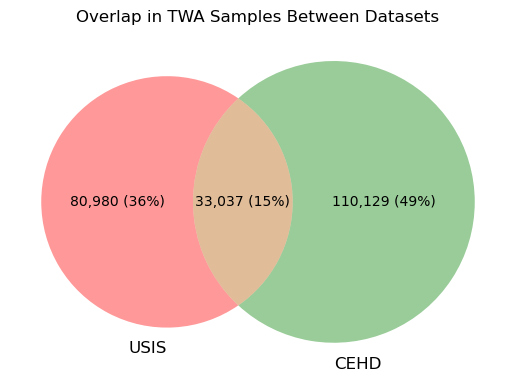

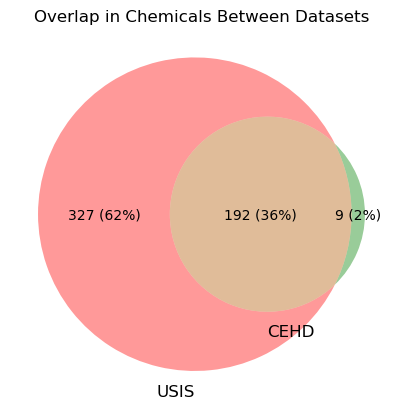

In [4]:
usis_chem_ids = twa_usis.index.get_level_values(config.usis['chem_id_col'])
usis_sampling_nos = twa_usis.index.get_level_values(config.usis['sampling_number_col'])
cehd_chem_ids = twa_cehd.index.get_level_values(config.cehd['chem_id_col'])
cehd_sampling_nos = twa_cehd.index.get_level_values(config.cehd['sampling_number_col'])

plot.dataset_overlap_venn(
    set(zip(usis_chem_ids, usis_sampling_nos)), 
    set(zip(cehd_chem_ids, cehd_sampling_nos)), 
    title='Overlap in TWA Samples Between Datasets',
    write_path='figures/twa_samples_venn.png'
)

plot.dataset_overlap_venn(
    set(usis_chem_ids.unique()), 
    set(cehd_chem_ids.unique()), 
    title='Overlap in Chemicals Between Datasets',
    write_path='figures/chemicals_venn.png'
)

In [2]:
usis_targets = data_management.read_targets(config.path['usis_target_dir'])
cehd_targets = data_management.read_targets(config.path['cehd_target_dir'])
combined_targets = data_management.read_targets(config.path['target_dir'])

sorted_naics_levels = config.cehd['naics_levels']
usis_targets = {k : usis_targets[k] for k in sorted_naics_levels}
cehd_targets = {k : cehd_targets[k] for k in sorted_naics_levels}
combined_targets = {k : combined_targets[k] for k in sorted_naics_levels}

opera_features = pd.read_parquet(config.path['opera_features_file'])

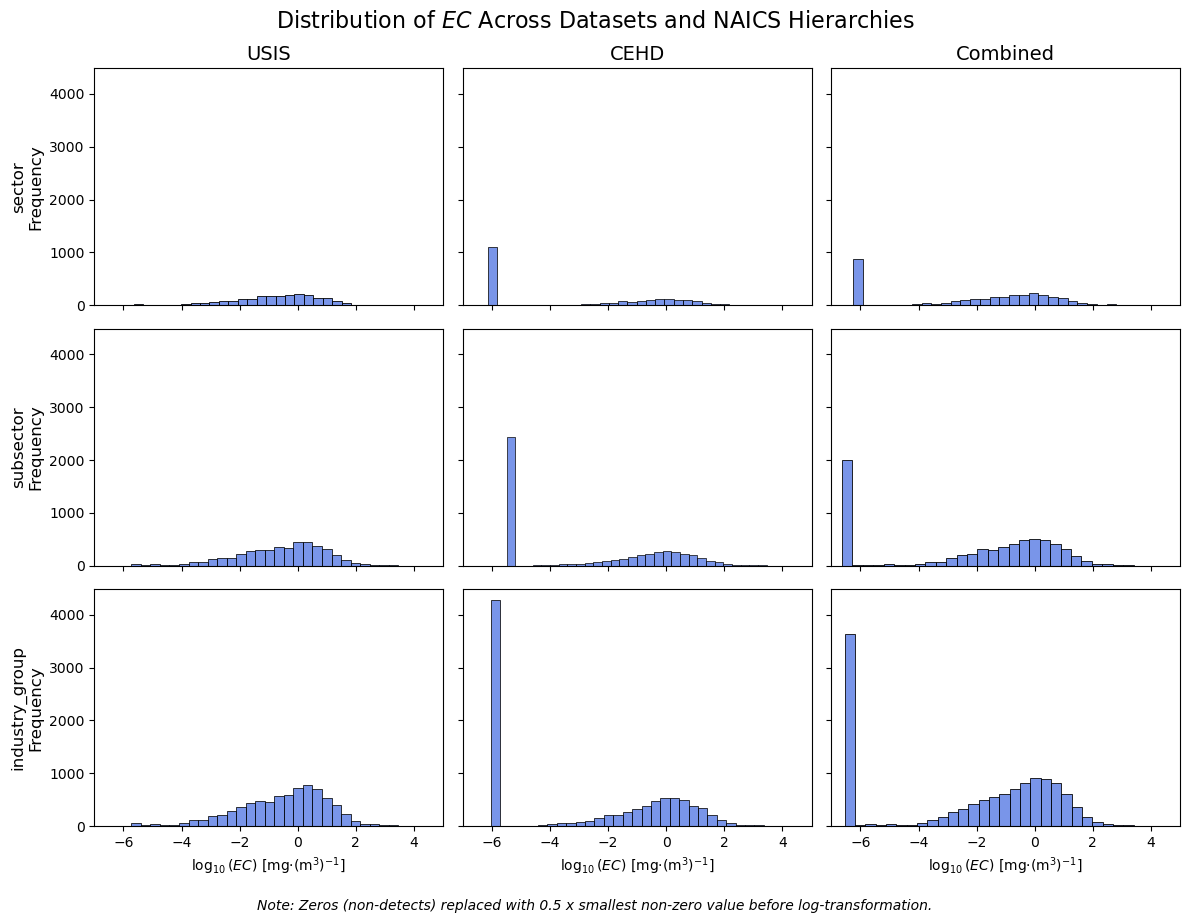

In [3]:
data = {
    'USIS' : usis_targets, 
    'CEHD' : cehd_targets,
    'Combined' : combined_targets
}

plot.histogram_grid(data, write_path='figures/histogram_grid.png')

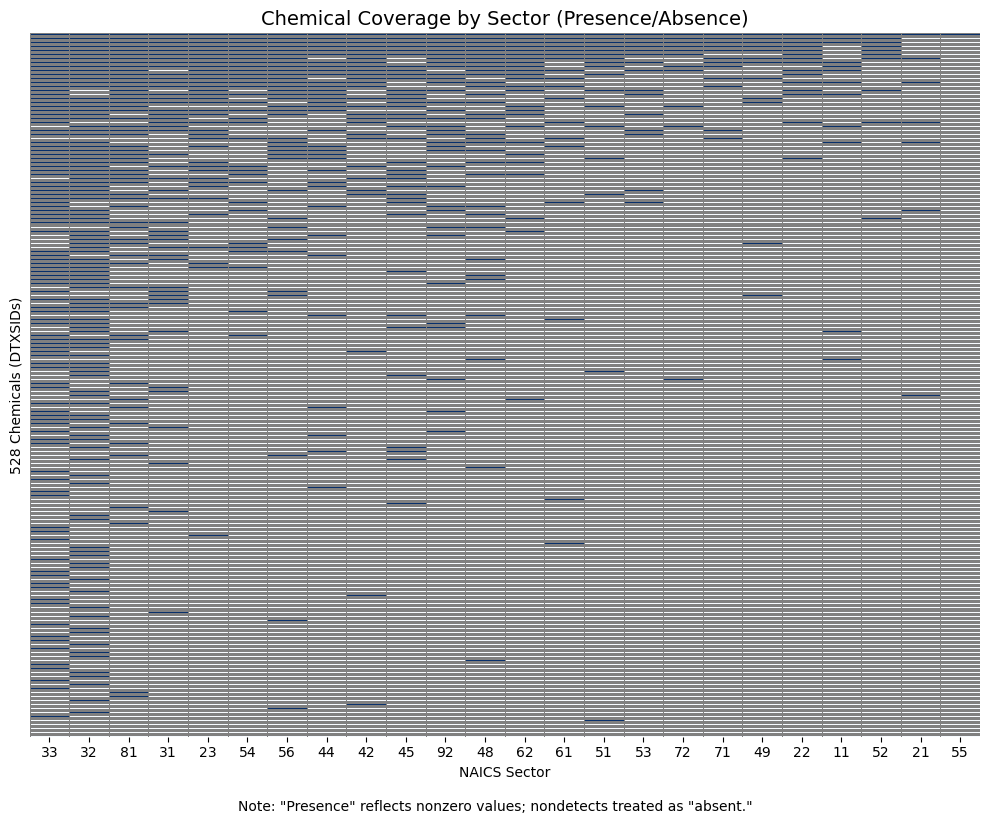

In [3]:
plot.chemical_coverage_heatmap(
    combined_targets['sector'], 
    write_path='figures/chemical_coverage_heatmap.png'
)

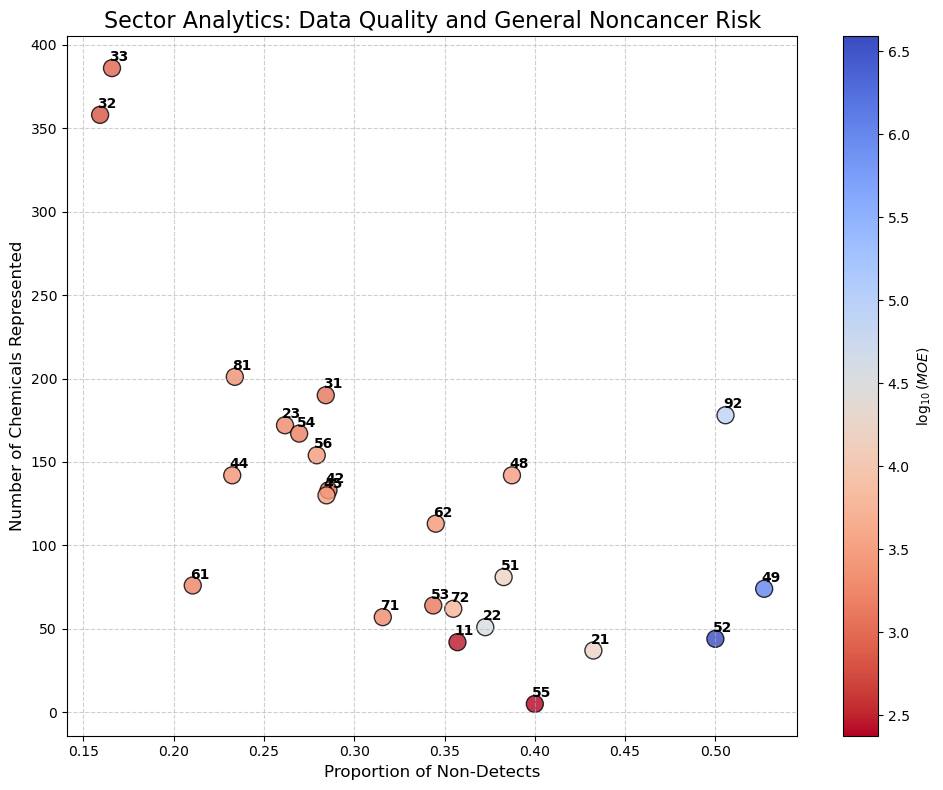

In [3]:
pod_data = pd.read_parquet(config.path['pod_file'])

pods = pod_data['general'].copy()

exposures = plot.preprocess_target(combined_targets['sector'], log10=False).copy()
pods = (
    pods
    .reindex(exposures.index.get_level_values('DTXSID'))
    .to_frame()
    .set_index(exposures.index)
    .squeeze()
)

moes = np.log10(pods / exposures)

plot.naics_level_data_summary(
    combined_targets['sector'], 
    moes, 
    write_path='figures/sector_data_quality.png'
)

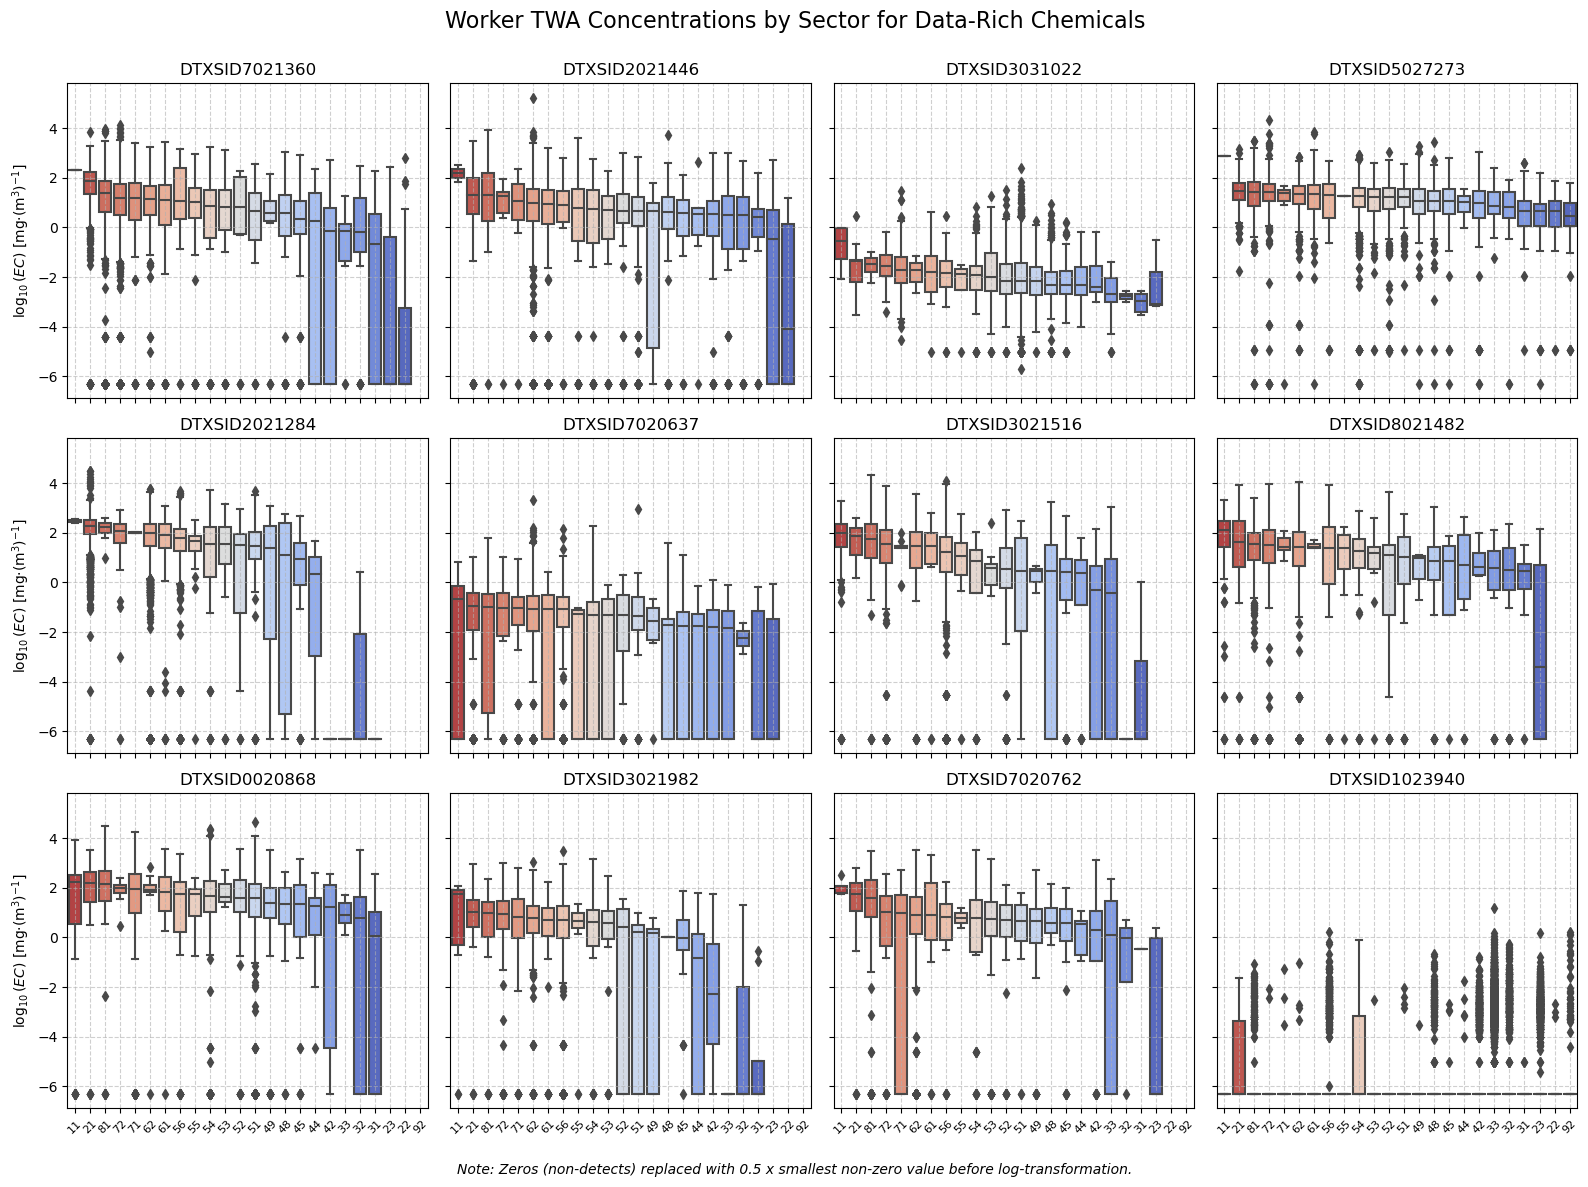

In [4]:
# NOTE: Wow, there is a consistent sector trend across all the chemicals 

# Get the TWAs on a per worker basis
y_by_sampling_no = osha_processing.reindex_with_naics_level(
    twa_combined.droplevel('inspection_number'), 
    config.usis['naics_code_col'], 
    'sector'
).rename('concentration')

most_data_rich_chemicals = (
    y_by_sampling_no
    .replace(0., np.nan)
    .dropna()
    .groupby('DTXSID')
    .count()
    .sort_values(ascending=False)
    .iloc[:12]
    .index
    .to_list()
)

plot.twa_concentrations_by_naics(
    y_by_sampling_no.loc[most_data_rich_chemicals],
    write_path='figures/twa_concentrations_by_sector.png'
)

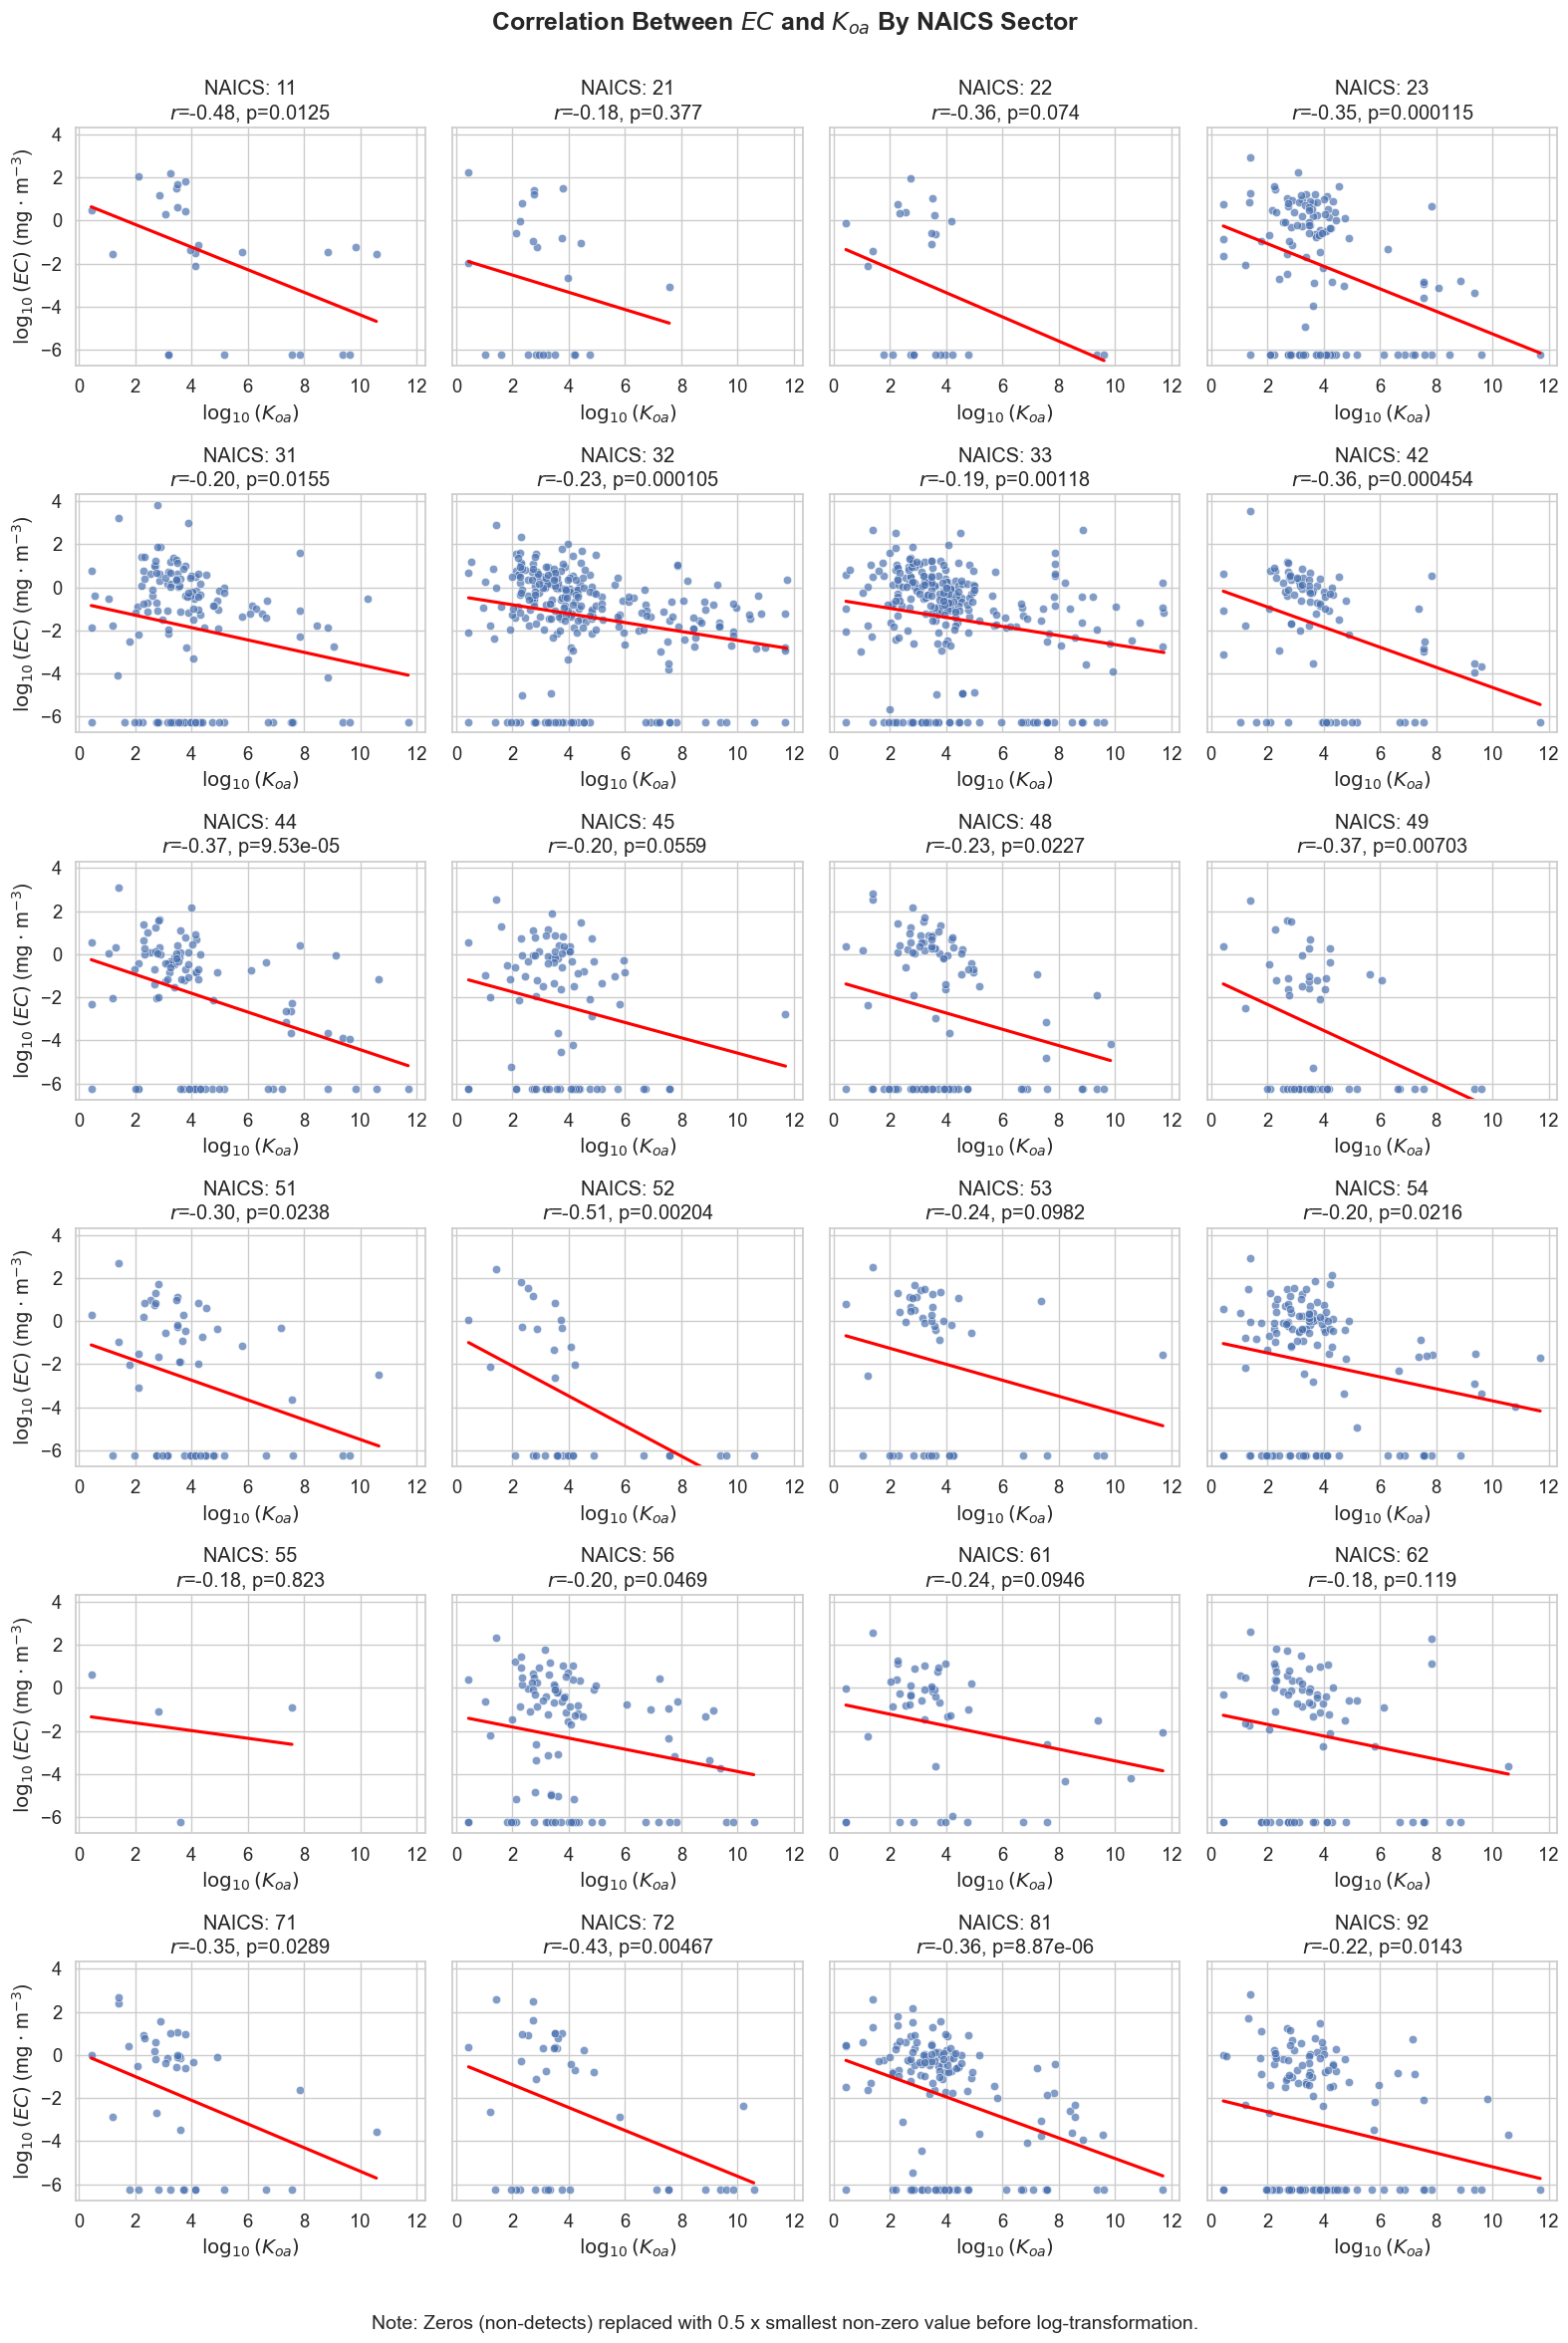

In [3]:
plot.correlation_by_naics(
    combined_targets['sector'],
    opera_features,
    write_path='figures/correlation_by_naics.png'
)